In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from time import time

from gem.utils      import graph_util, plot_util
from gem.evaluation import visualize_embedding as viz
from gem.evaluation import evaluate_graph_reconstruction as gr

from gem.embedding.hope     import HOPE

from sklearn.datasets import make_blobs
import numpy as np
import math
import scipy as sp
import seaborn as sns

In [2]:
# File that contains the edges. Format: source target
# Optionally, you can add weights as third column: source target weight
edge_f = 'data/Edge.csv'
# Specify whether the edges are directed
isDirected = False

# Load graph
G = graph_util.loadGraphFromEdgeListTxt(edge_f, directed=isDirected)
G = G.to_directed()

In [3]:
models = []
models.append(HOPE(d=4, beta=0.01))

In [4]:
for embedding in models:
    print ('Num nodes: %d, num edges: %d' % (G.number_of_nodes(), G.number_of_edges()))
    t1 = time()
    # Learn embedding - accepts a networkx graph or file with edge list
    Y, t = embedding.learn_embedding(graph=G, edge_f=None, is_weighted=True, no_python=True)
    print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))
    # Evaluate on graph reconstruction
    MAP, prec_curv, err, err_baseline = gr.evaluateStaticGraphReconstruction(G, embedding, Y, None)
    #---------------------------------------------------------------------------------
    print(("\tMAP: {} \t preccision curve: {}\n\n\n\n"+'-'*100).format(MAP,prec_curv[:5]))
    #---------------------------------------------------------------------------------
    # Visualize
    viz.plot_embedding2D(embedding.get_embedding(), di_graph=G, node_colors=None)
    print(embedding.get_embedding()[:, :2])
    plt.show()
    plt.clf()

Num nodes: 453, num edges: 114990
SVD error (low rank): 0.511820
hope_gsvd:
	Training time: 0.107154
	MAP: 0.5847789373276353 	 preccision curve: [0.0, 0.0, 0.0, 0.25, 0.2]



----------------------------------------------------------------------------------------------------
Embedding dimension greater than 2, use tSNE to reduce it to 2
[[-0.04321776  0.03311501]
 [-0.03006656  0.0147348 ]
 [-0.01583338  0.07299719]
 [-0.02979263  0.01480469]
 [-0.04676915  0.04556219]
 [-0.01684385  0.07575565]
 [-0.05430821  0.04296649]
 [-0.03556258  0.02870149]
 [-0.03004734  0.01236677]
 [-0.03893721  0.03182314]
 [-0.02994599  0.01467238]
 [-0.03174067  0.01713588]
 [-0.01570374  0.05907817]
 [-0.05430821  0.04296649]
 [-0.0047856   0.05711211]
 [-0.05031726  0.05435473]
 [-0.01650977  0.07551121]
 [-0.04967866  0.05275739]
 [-0.00559955  0.05659271]
 [-0.04430901  0.03717558]
 [-0.00492868  0.06111858]
 [-0.01577779  0.07252348]
 [-0.01708999  0.05816912]
 [-0.01987505  0.02184811]
 [-0.0371185

<ipython-input-4-f7f8d0fc798a>:15: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [13]:
x, y = make_blobs(n_samples=100, centers=4, n_features=2, random_state=6)

Embedding = pd.DataFrame(embedding.get_embedding()[:, :2])
Embedding.columns = ['x', 'y']
Embedding

,x,y
0,-0.043218,0.033115
1,-0.030067,0.014735
2,-0.015833,0.072997
3,-0.029793,0.014805
4,-0.046769,0.045562
...,...,...
448,0.040852,0.065654
449,0.013419,0.025864
450,0.011412,0.030201
451,0.013428,0.025458


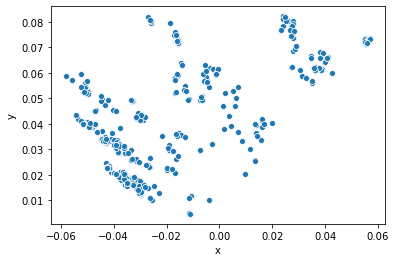

In [17]:
# 시각화하여 k 값을 정함

%matplotlib inline
sns.scatterplot(x='x', y='y', data=Embedding, palette='Set2');

In [19]:
# 중심점(centroid) 구함: random하게 6개의 점을 첫번째 중심점으로 삼음

centroids = Embedding.sample(6, random_state=1)
centroids

,x,y
207,-0.043573,0.033658
283,-0.036562,0.020866
65,-0.005279,0.063082
197,-0.012807,0.052780
208,-0.051559,0.040086
277,-0.036500,0.020802


In [22]:
# 각 중심점으로부터의 거리를 구하여 가까운 중심점의 cluster로 할당

# 각 데이터에 대해, 각 중심점과의 유클리드 거리 계싼
distance = sp.spatial.distance.cdist(Embedding, centroids, 'euclidean')

# 가장 거리가 짧은 중심점의 cluster로 할당
cluster_num = np.argmin(distance, axis=1)

# 결과 확인
result = Embedding.copy()
result["cluster"] = np.array(cluster_num)
result

,x,y,cluster
0,-0.043218,0.033115,0
1,-0.030067,0.014735,5
2,-0.015833,0.072997,2
3,-0.029793,0.014805,5
4,-0.046769,0.045562,4
...,...,...,...
448,0.040852,0.065654,2
449,0.013419,0.025864,3
450,0.011412,0.030201,3
451,0.013428,0.025458,3


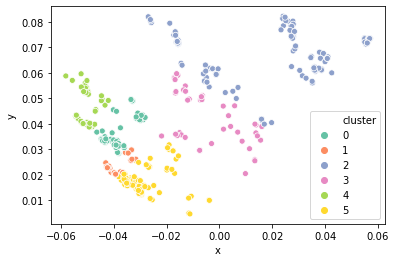

In [24]:
sns.scatterplot(x='x', y='y', hue='cluster', data=result, palette="Set2")

In [25]:
# 변경된 cluster에 대해서 중심점 구함: cluster의 중심점은 x좌표의 평균과 y좌표의 평균

# cluster별로 묶어서 평균 계산
centroids_2 = result.groupby('cluster').mean()
centroids_2

,x,y
cluster,,
0,-0.038148,0.036678
1,-0.037849,0.023739
2,0.023175,0.067807
3,-0.003915,0.042437
4,-0.050299,0.047038
5,-0.027925,0.016982


            x         y  cluster
0   -0.043218  0.033115        0
1   -0.030067  0.014735        5
2   -0.015833  0.072997        2
3   -0.029793  0.014805        5
4   -0.046769  0.045562        4
..        ...       ...      ...
448  0.040852  0.065654        2
449  0.013419  0.025864        3
450  0.011412  0.030201        3
451  0.013428  0.025458        3
452  0.009861  0.020437        3

[453 rows x 3 columns]


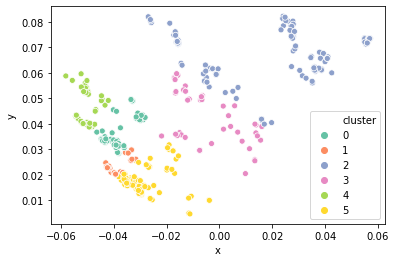

In [26]:
# 각 데이터에 대해, 각 중심점과의 유클리드 거리 계싼
distance = sp.spatial.distance.cdist(Embedding, centroids, 'euclidean')

# 가장 거리가 짧은 중심점의 cluster로 할당
cluster_num = np.argmin(distance, axis=1)

# 결과 확인
result = Embedding.copy()
result["cluster"] = np.array(cluster_num)
print(result)

sns.scatterplot(x='x', y='y', hue='cluster', data=result, palette="Set2")